In [8]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from data.mouse import create_mice_dict
from plotting.main_plotting import plot_session_events_and_signal
from analysis.timepoint_analysis import sample_signals_and_metrics
from itertools import product

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
import numpy as np
import scipy.stats as stats

import config


sessions = load_and_prepare_sessions("../../../trial_Gq-DREADD_CPT", load_from_pickle=True, remove_bad_signal_sessions=True)
mouse_analyser = MiceAnalysis(sessions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
mice_dict = create_mice_dict(sessions)

In [10]:
# for session in sessions:
#     brain_reg = session.brain_regions[-1]  # Your brain region object

#     # Step 3: Create a Plotly figure object for subplots
#     # Adjust rows and cols based on your layout needs
#     fig = make_subplots(rows=1, cols=1)

#     # Step 4: Call the function with your specific parameters
#     title = f'{session.mouse_id}, {brain_reg}'
#     plot_session_events_and_signal(session, brain_reg, fig, row=1, col=1, title_suffix=title)

#     # Finally, show the figure
#     fig.show()

In [11]:
import matplotlib.pyplot as plt

In [12]:
# brain_reg_to_color = {'VS': 'purple',
#                       'DMS': 'forestgreen',
#                       'DLS': 'C0'}

brain_reg_to_color = {'LH': 'orange',
                      'mPFC': 'paleturquoise'}

In [13]:
import pickle

with open('all_signals_1.pickle', 'rb') as file:
    # Load the data back into a Python object
    all_signals_1 = pickle.load(file)

with open('all_signals_2.pickle', 'rb') as file:
    # Load the data back into a Python object
    all_signals_2 = pickle.load(file)

In [19]:
all_signals_1[('hit', 'LH')].shape

(4548, 400)

In [20]:
all_signals = {}

for k in all_signals_1.keys():
    all_signals[k] = np.vstack([all_signals_1[k], all_signals_2[k]])

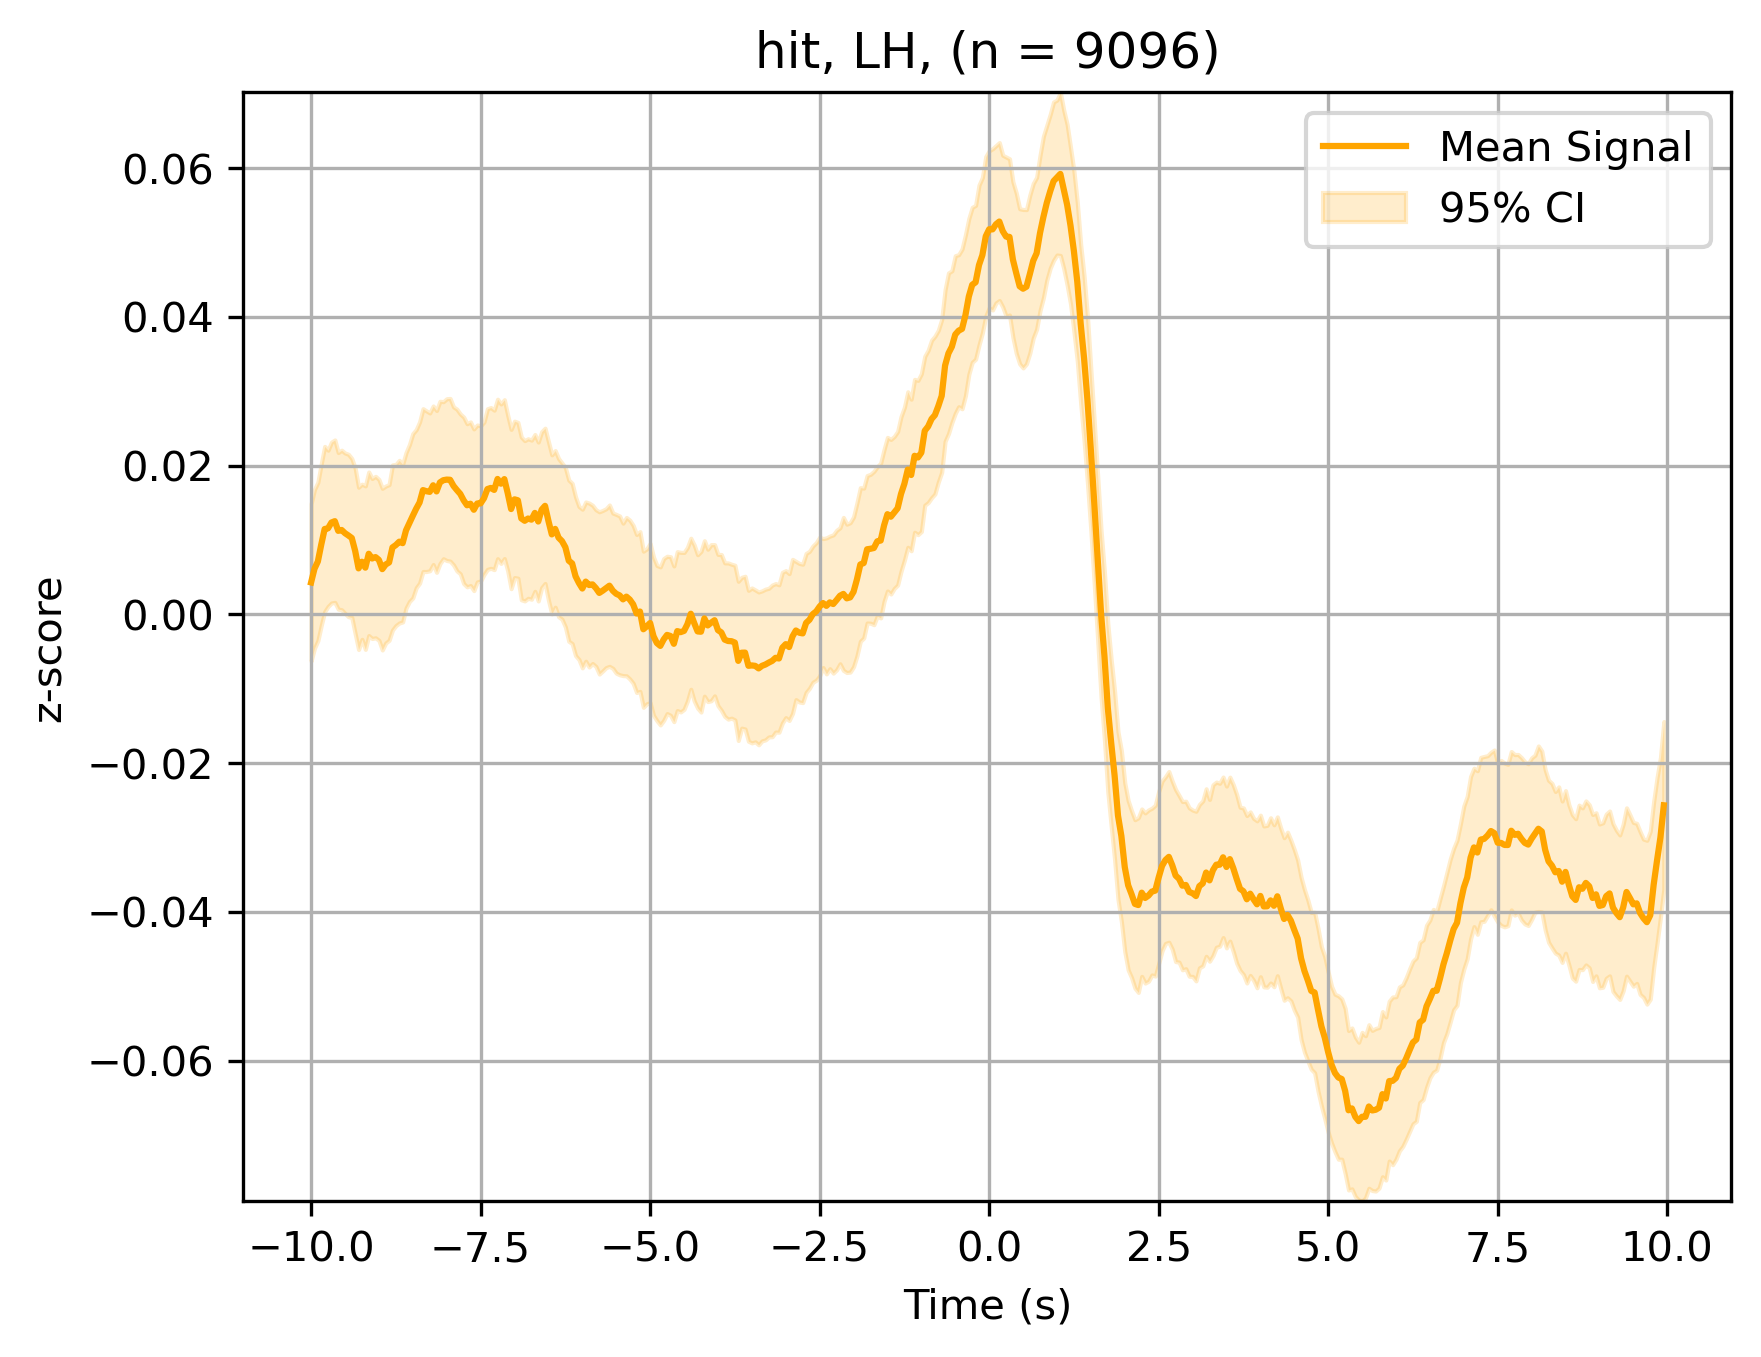

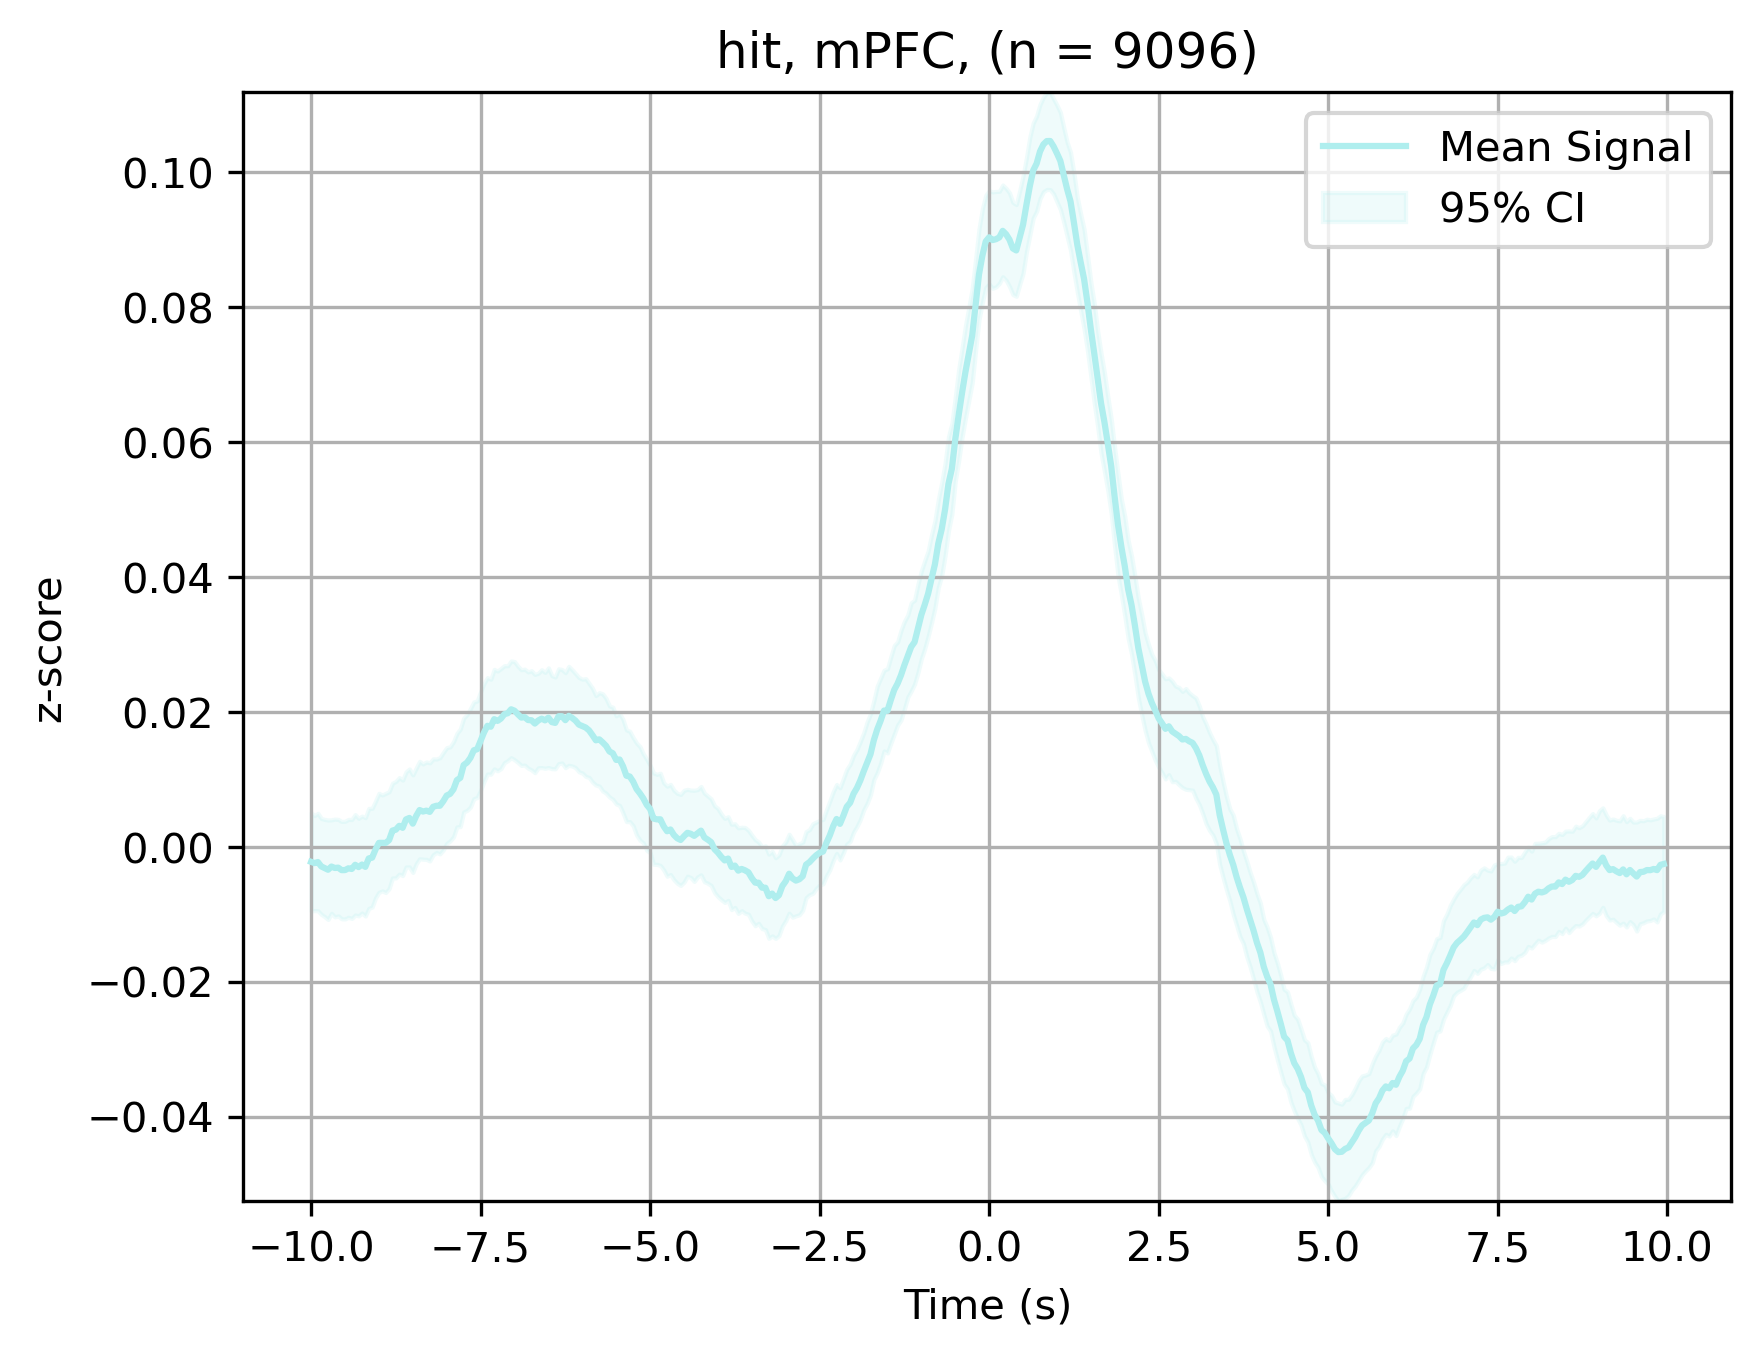

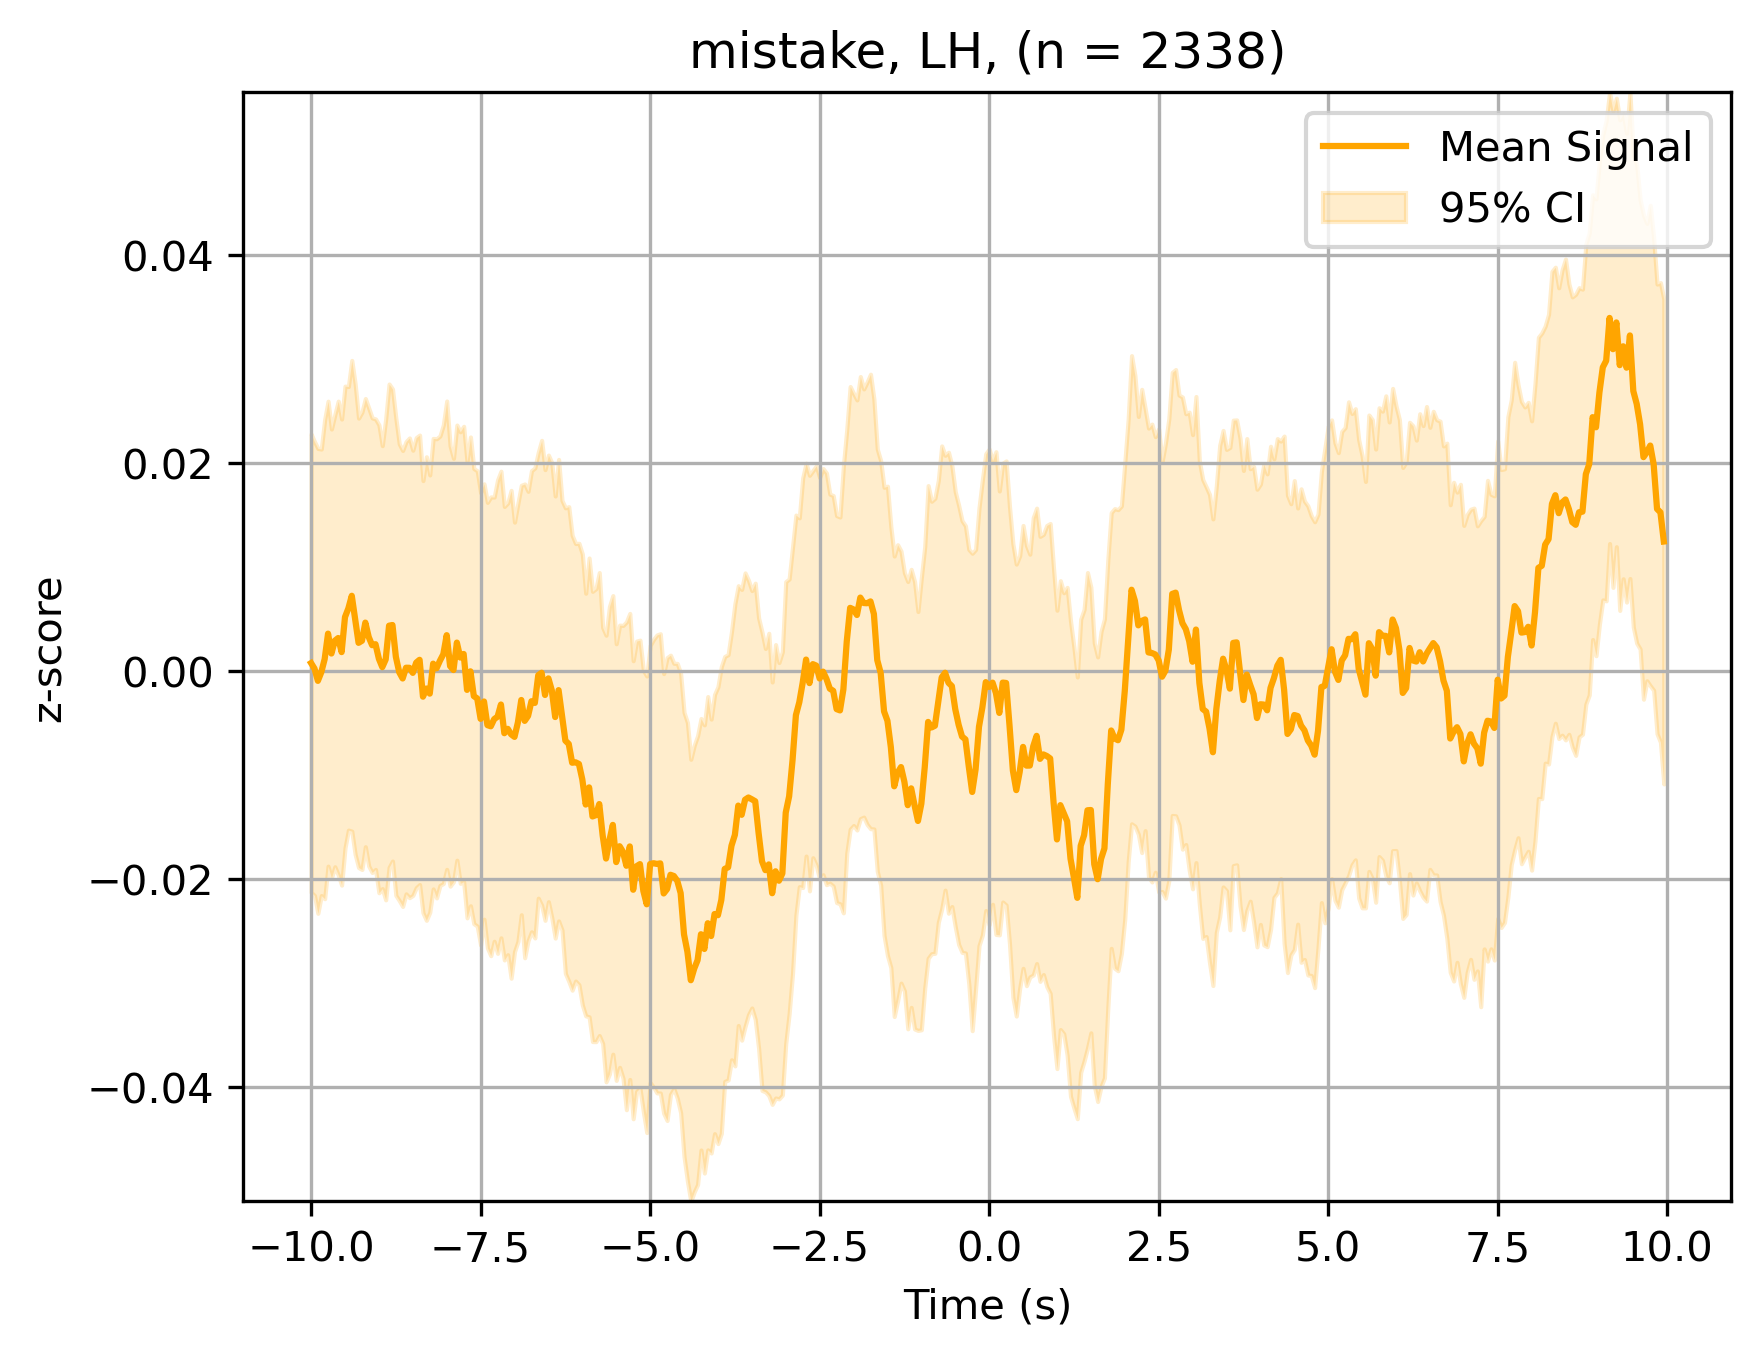

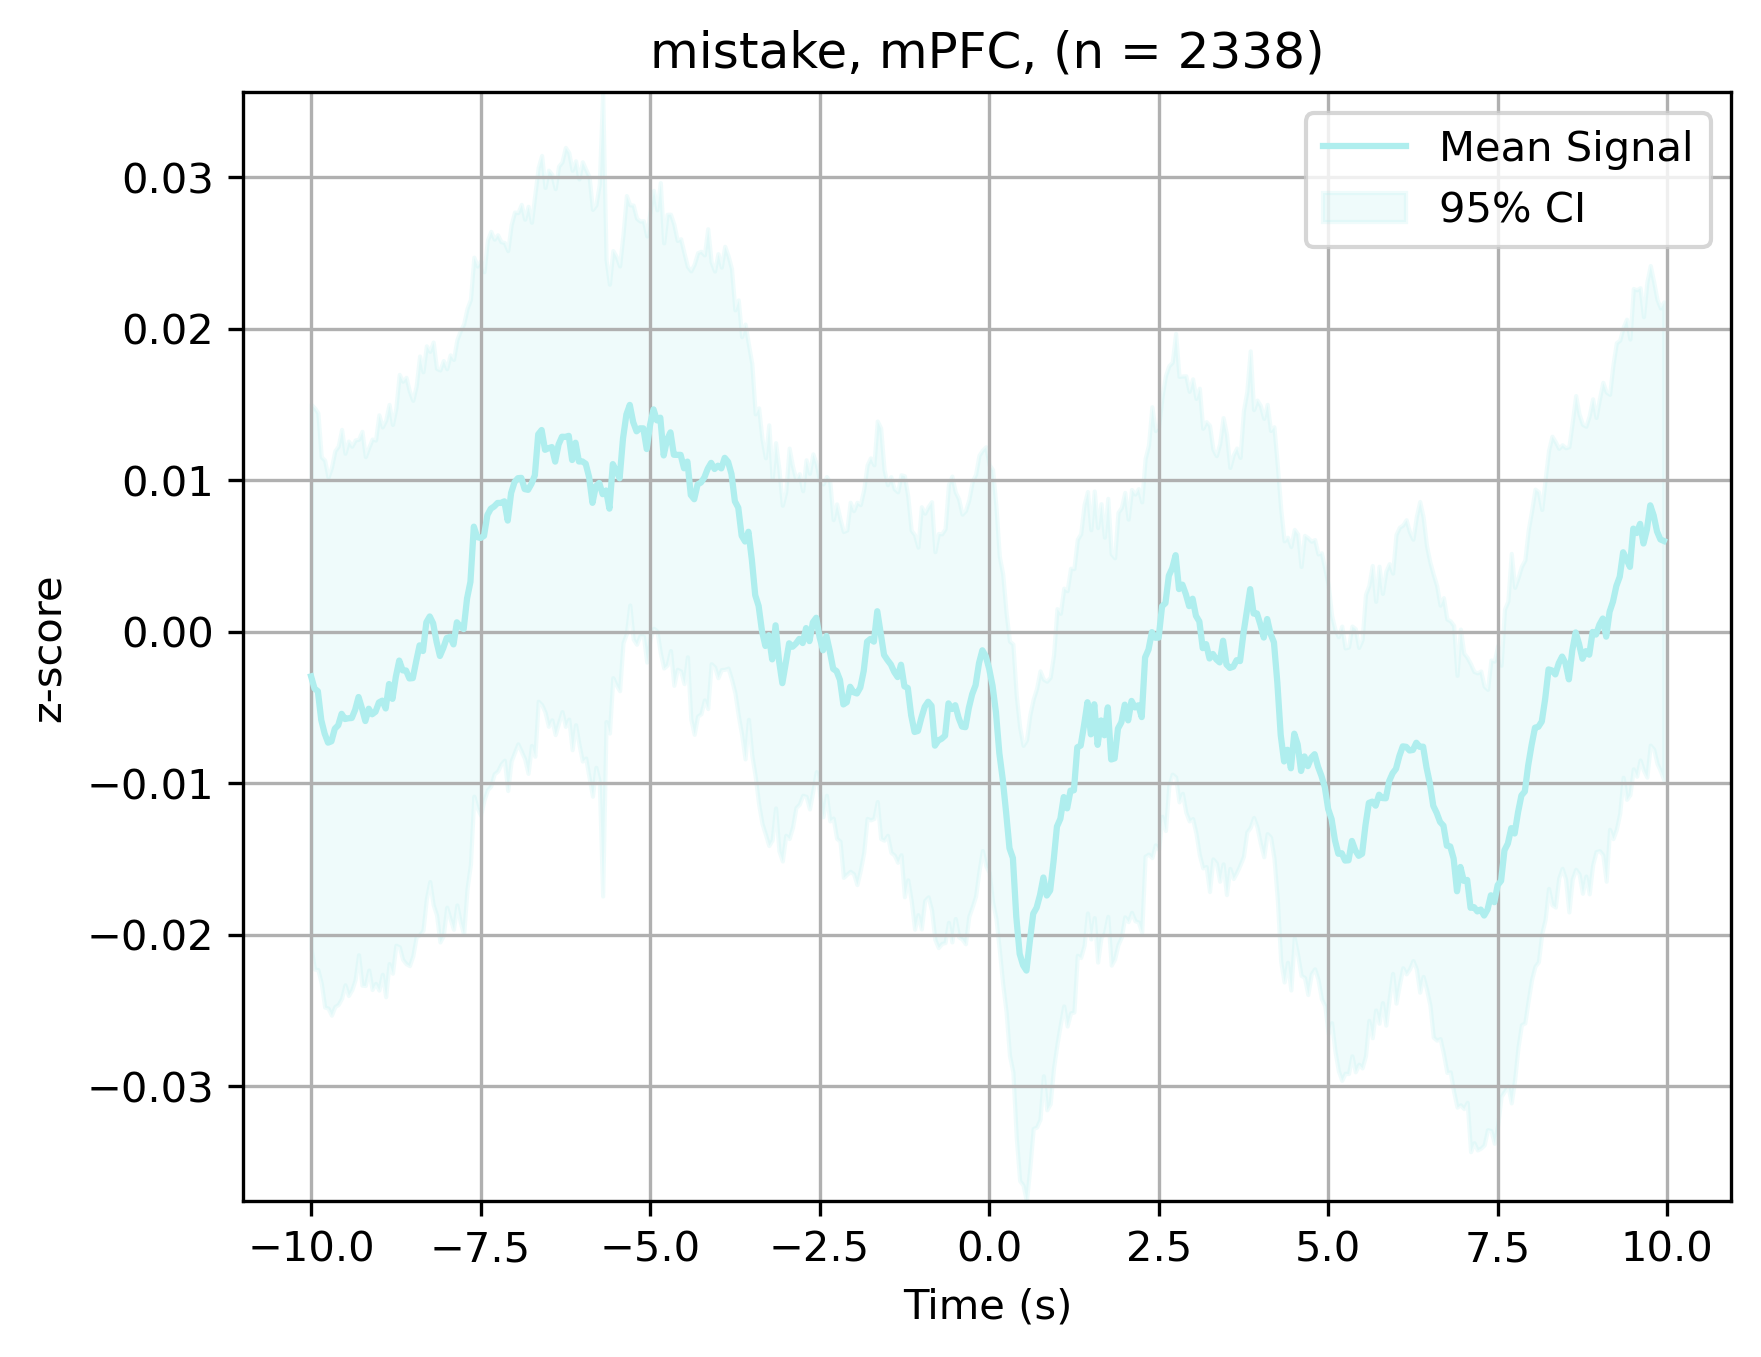

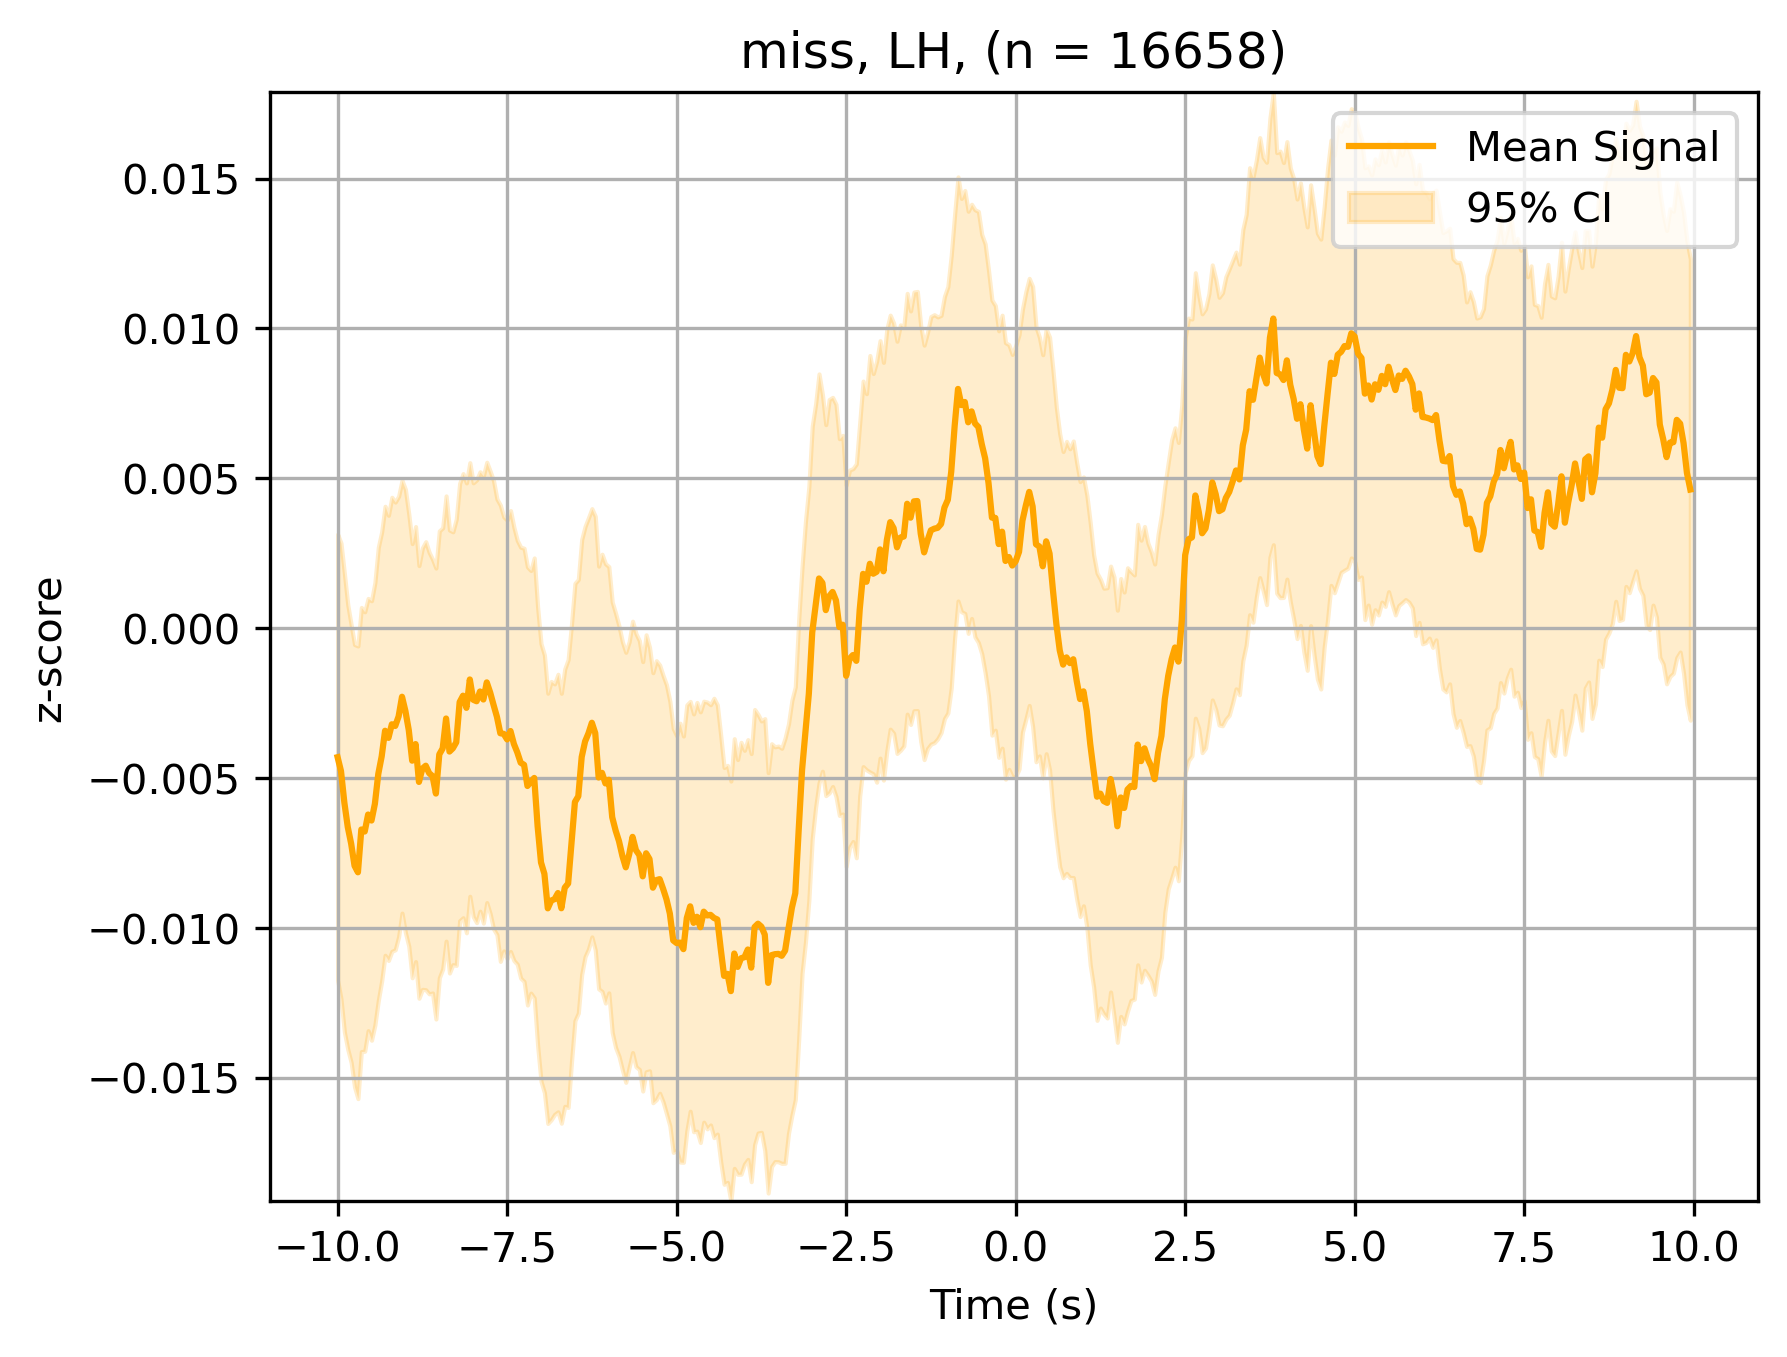

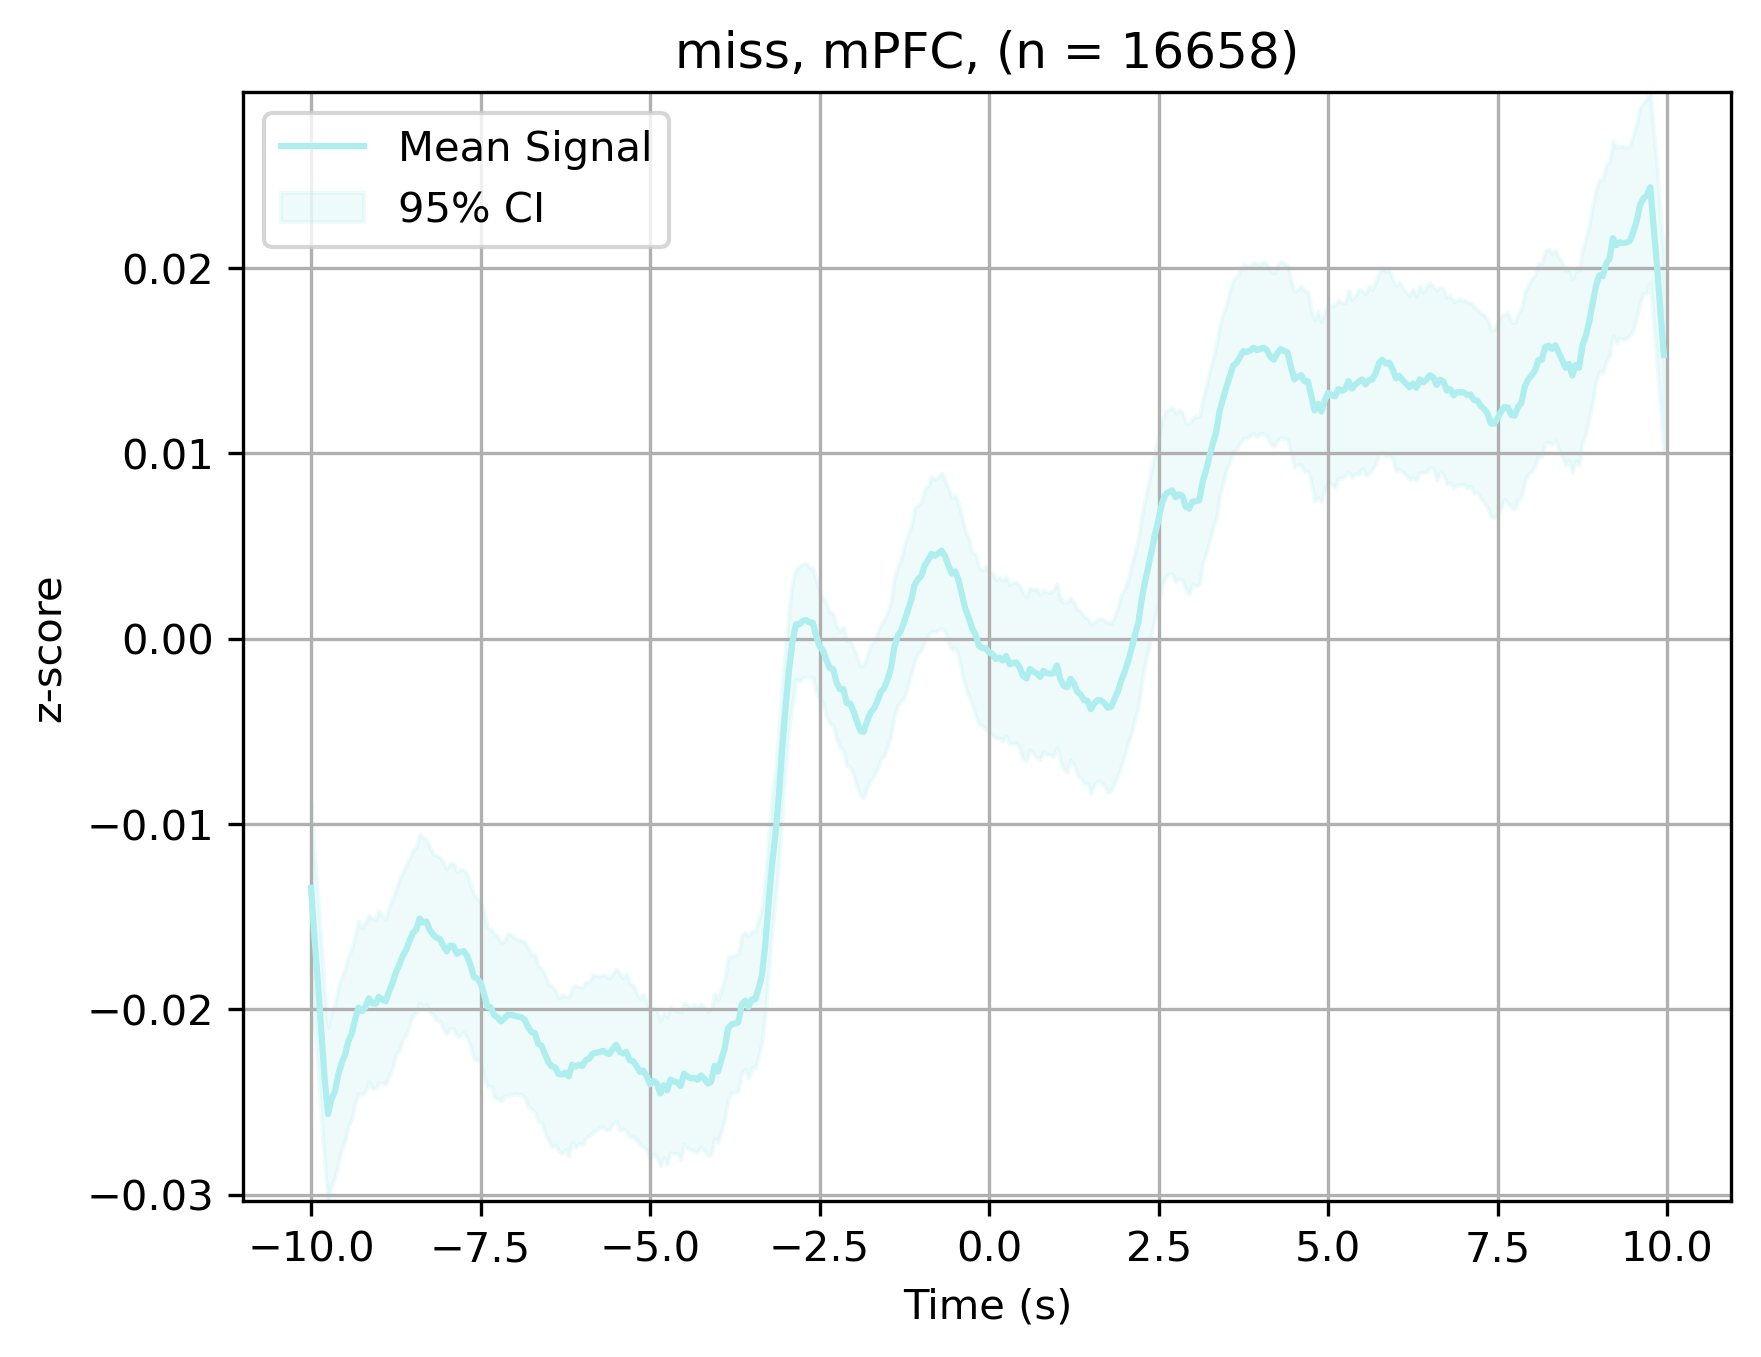

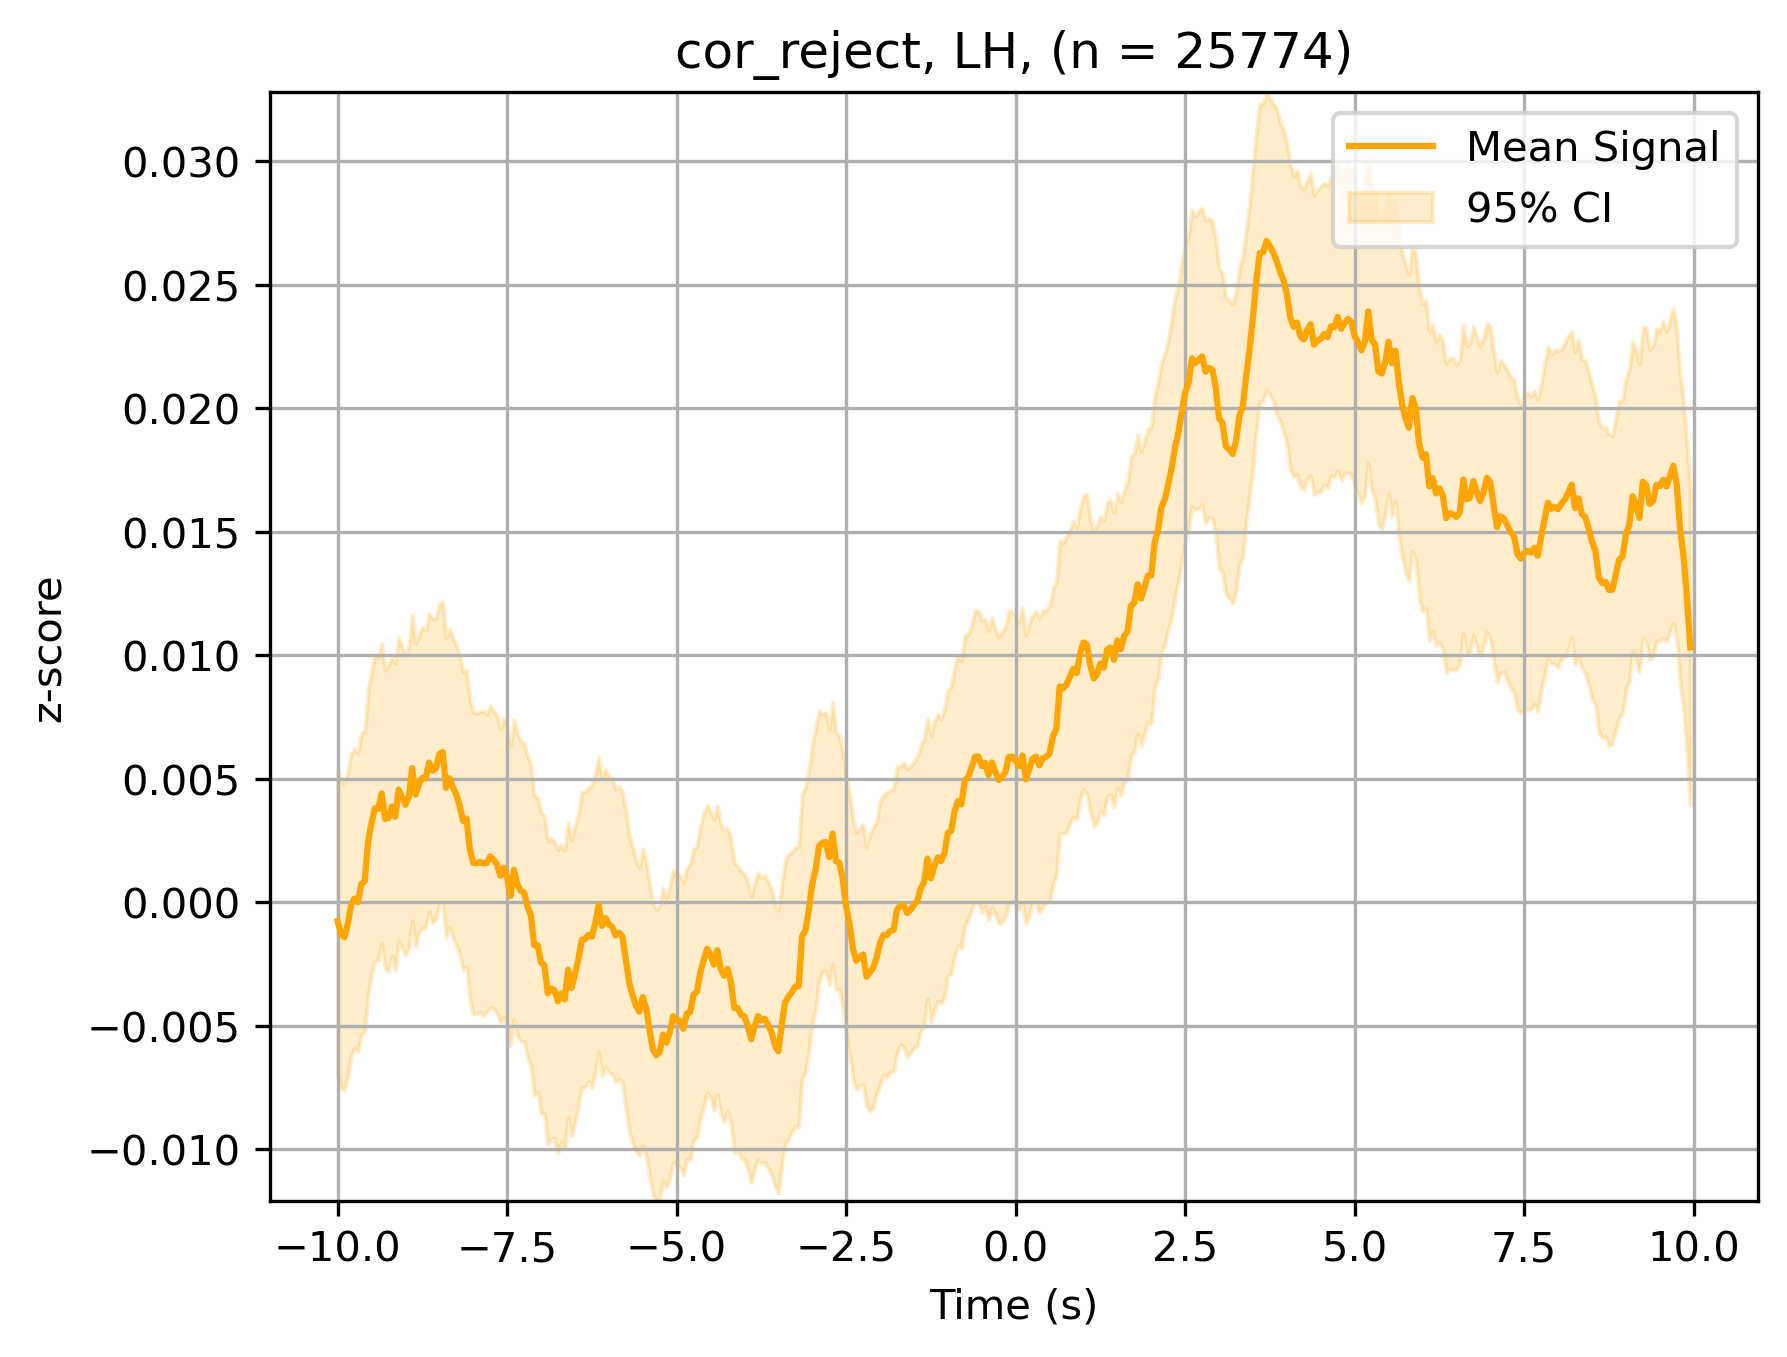

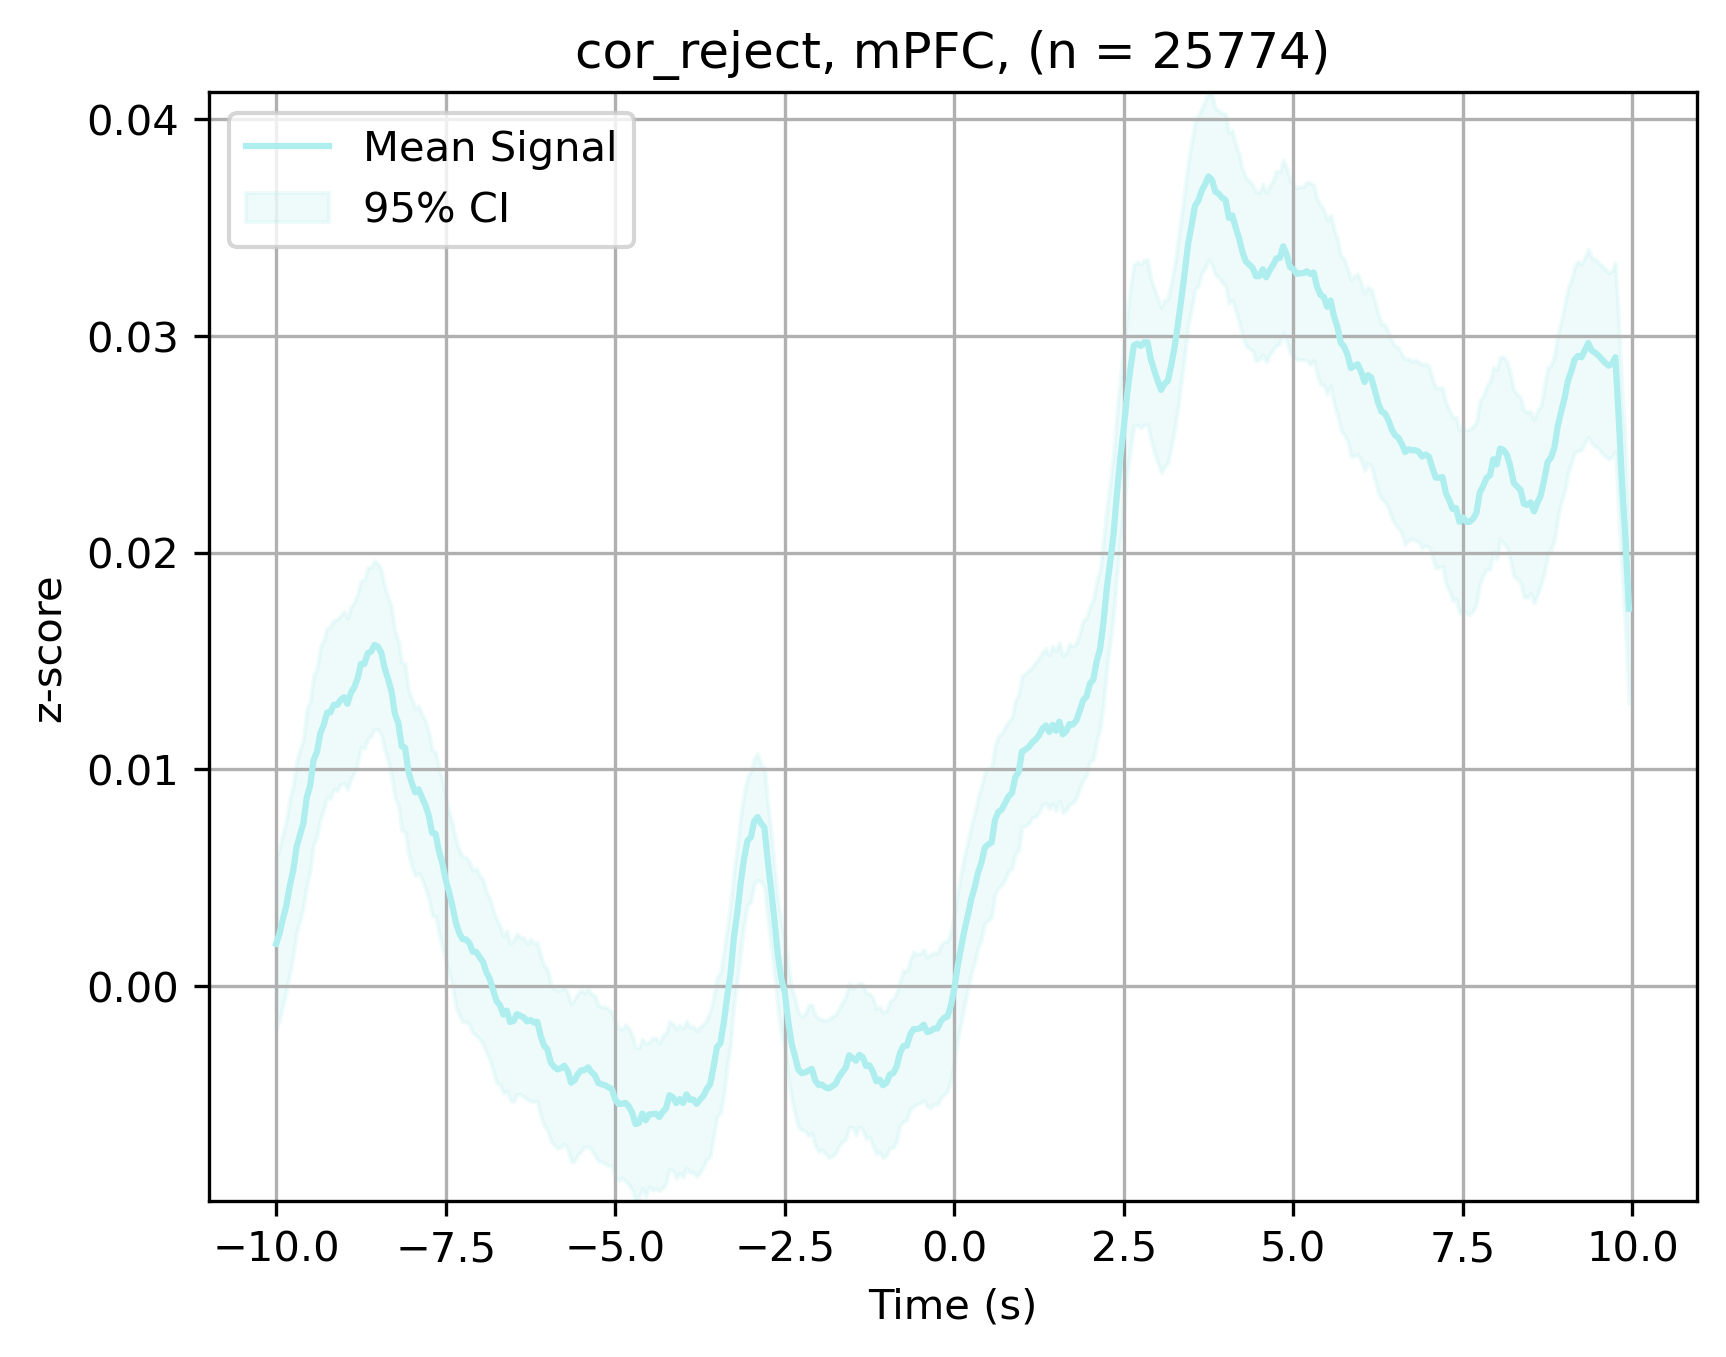

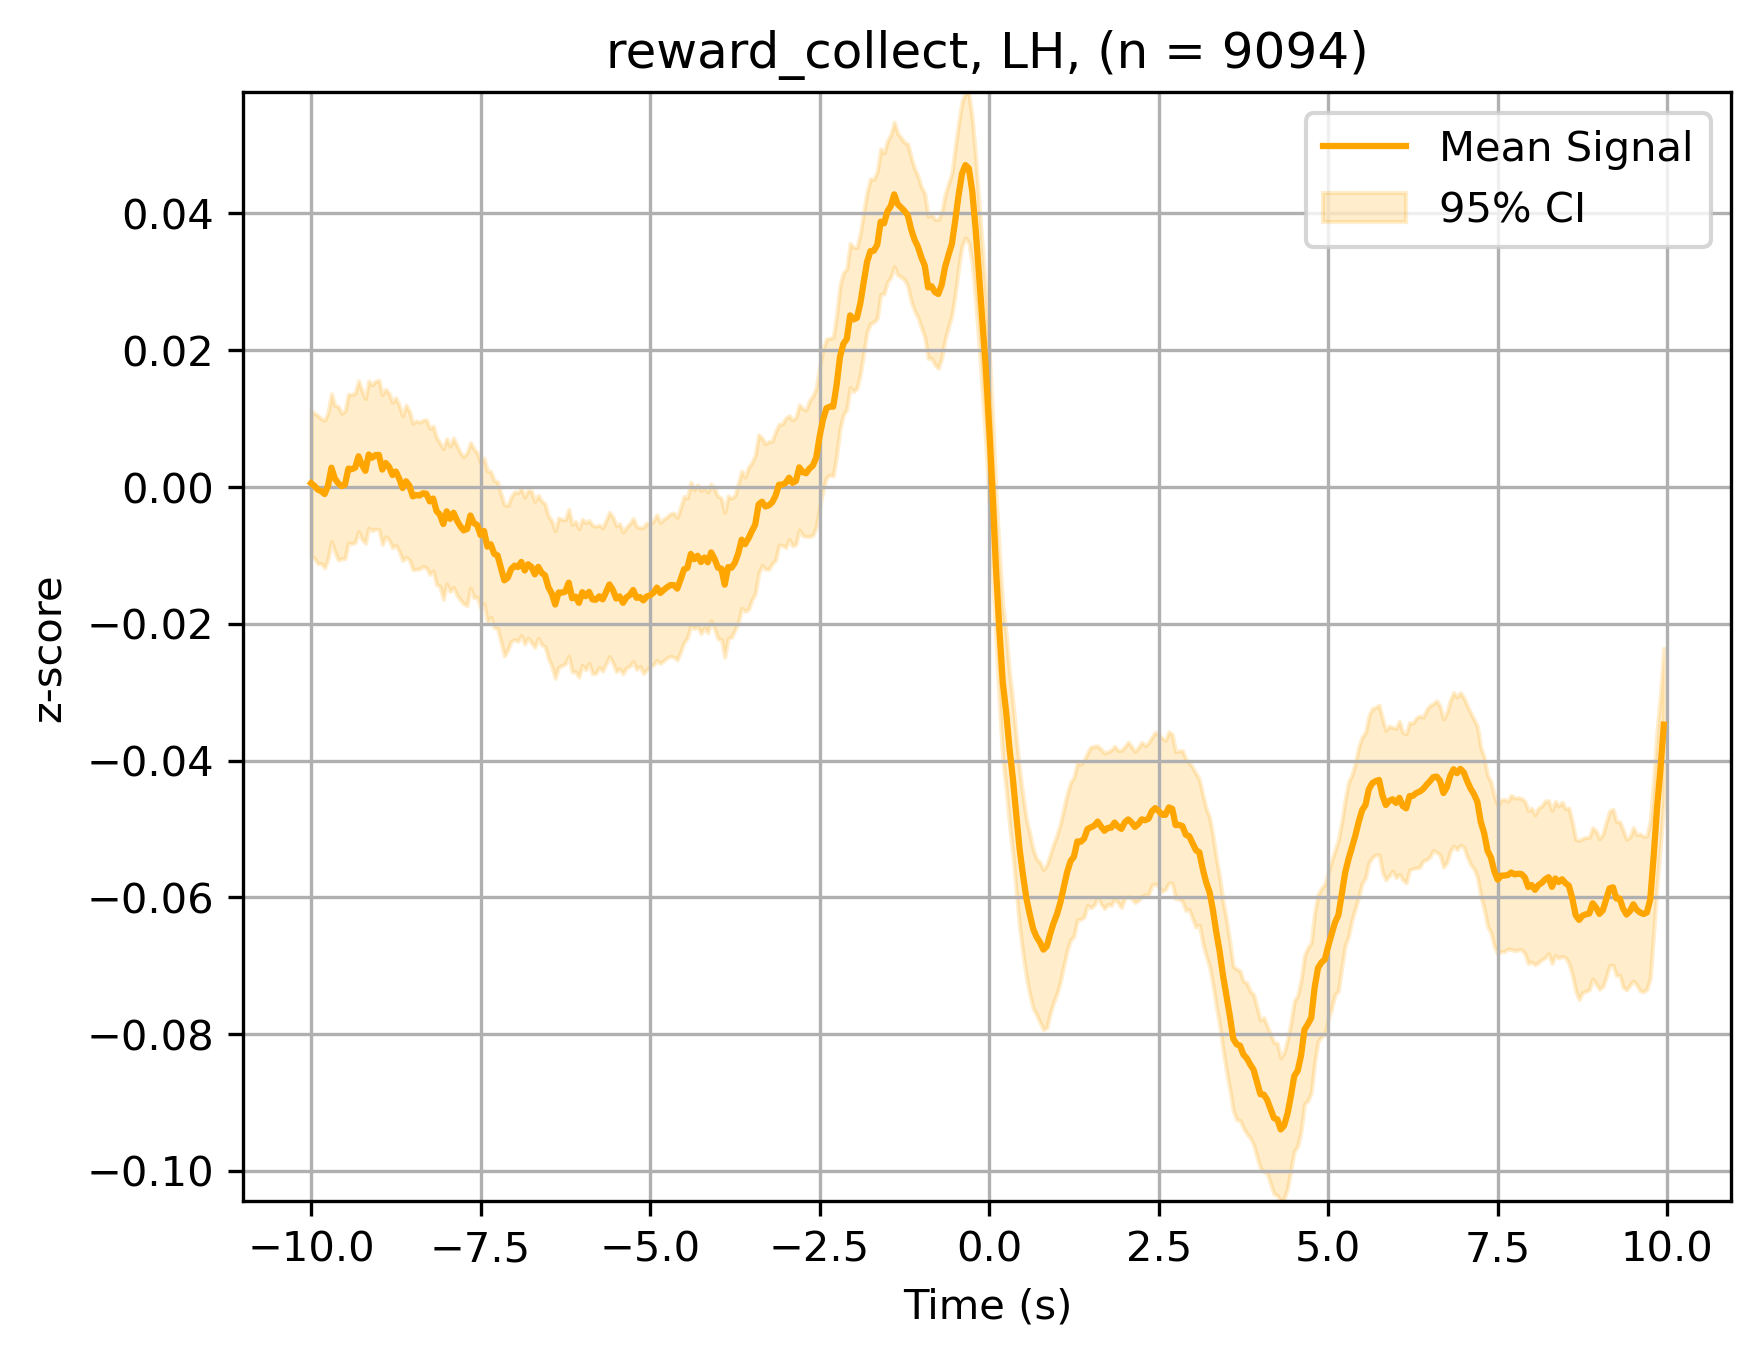

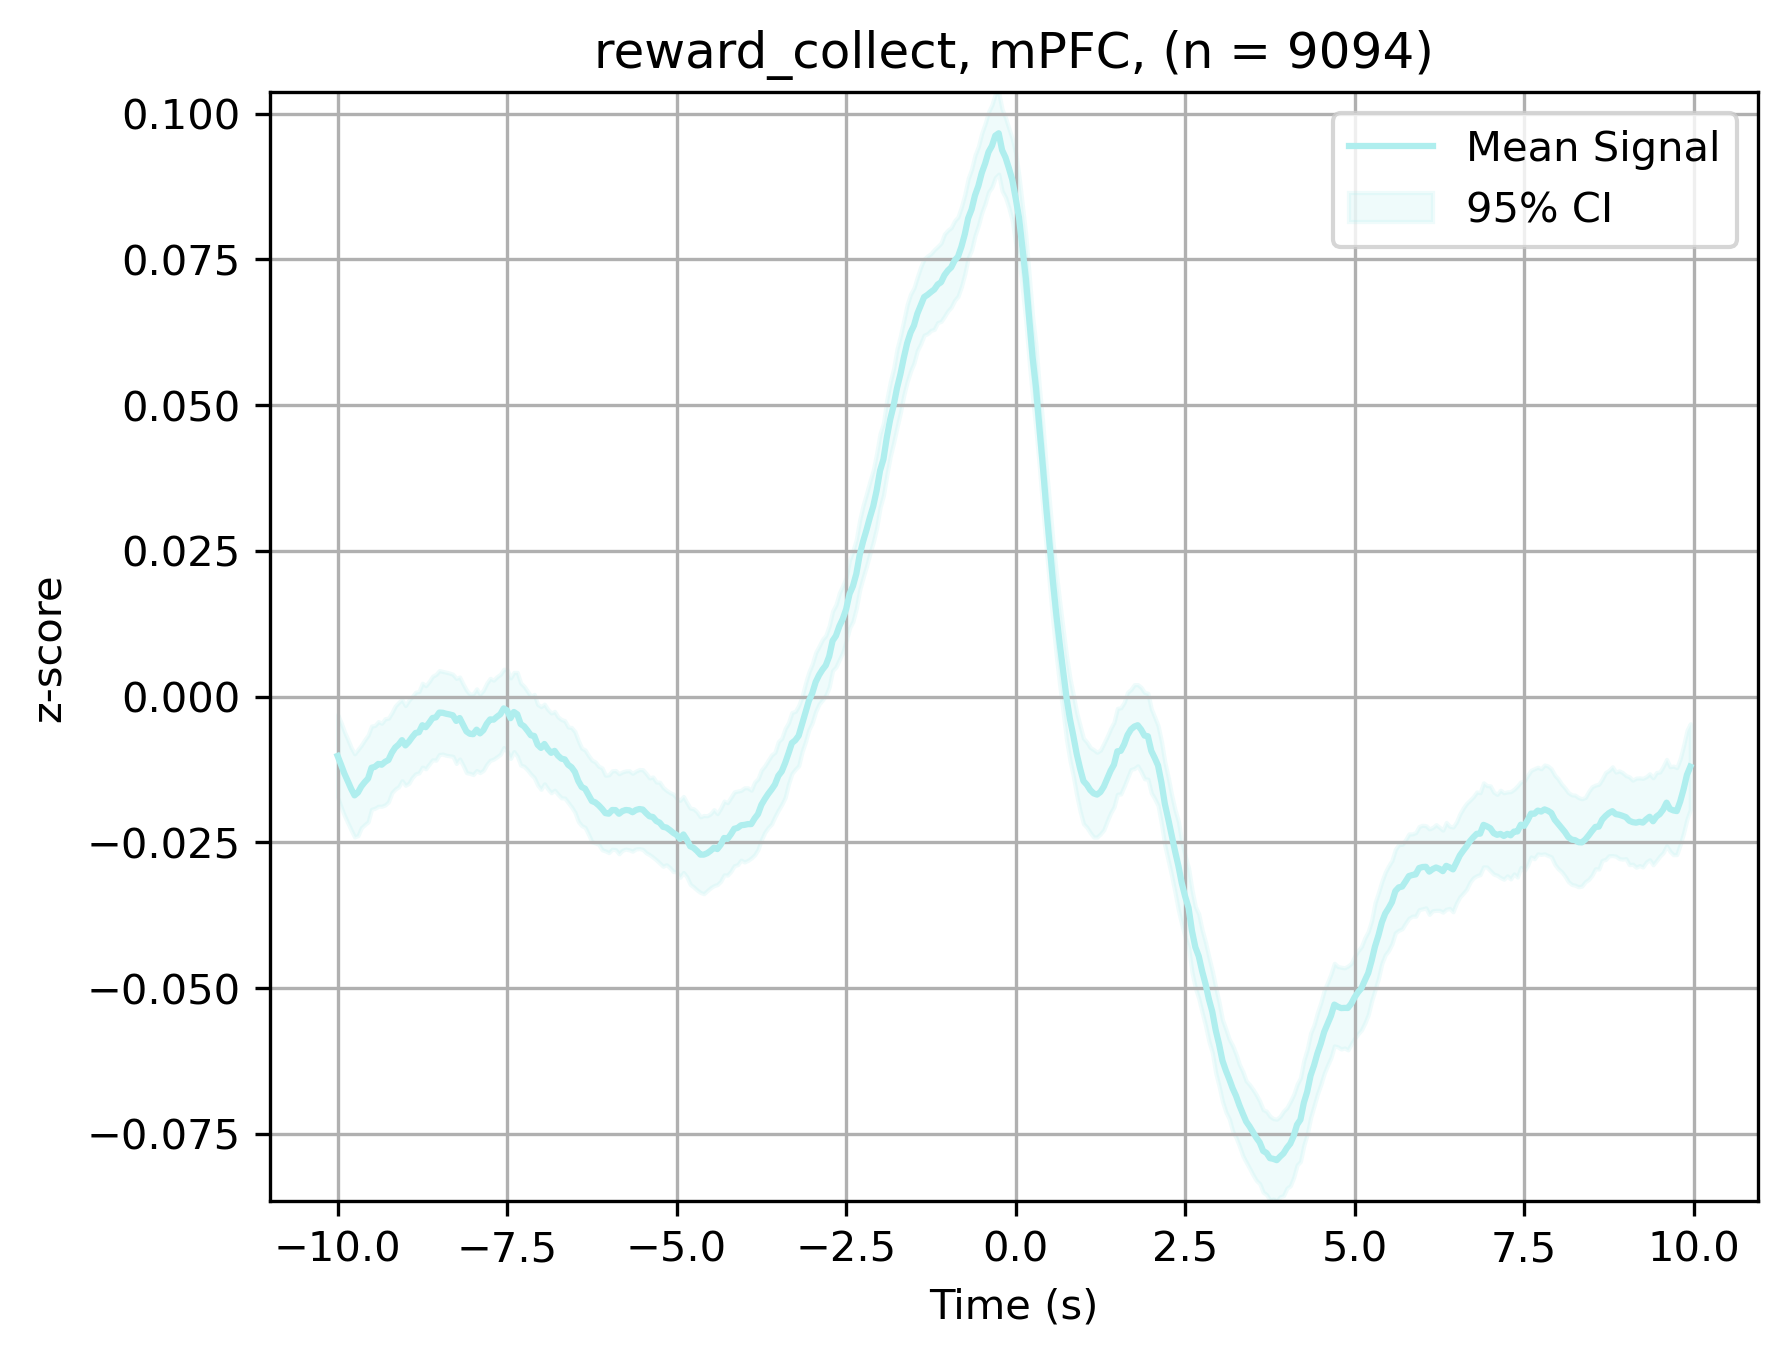

In [27]:
def preprocess_and_plot_signals(sessions, event_type, brain_region, smoothing_len=10):
    # Assuming all_signals is predefined
    signals = all_signals[(event_type, brain_region)]

    interval_start = config.peak_interval_config["interval_start"]
    interval_end = config.peak_interval_config["interval_end"]
    fps = config.PLOTTING_CONFIG['fps']
    
    xs = np.arange(-interval_start, interval_end) / fps
    
    # Smooth the mean signal
    ys = np.mean(signals, axis=0)
    window = np.ones(smoothing_len) / smoothing_len
    ys = np.convolve(ys, window, 'same')

    # Calculate the standard deviation of the mean
    std_signal = np.std(signals, axis=0) / np.sqrt(len(signals))

    # Use scipy.stats.norm.interval to get the 95% confidence interval
    alpha = 0.95
    ci_lower, ci_upper = stats.norm.interval(alpha, loc=ys, scale=std_signal)

    # The lower and upper bounds
    lb = ci_lower.min()
    ub = ci_upper.max()

    ylim = (lb, ub)
    
    # Assuming brain_reg_to_color is predefined
    color = brain_reg_to_color[brain_region]

    plt.figure(dpi=300)
    plt.plot(xs, ys, color=color, label='Mean Signal')
    plt.fill_between(xs, ci_lower, ci_upper, color=color, alpha=0.2, label='95% CI')
    plt.ylim(ylim)
    plt.title(f'{event_type}, {brain_region}, (n = {len(signals)})')
    plt.xlabel('Time (s)')
    plt.ylabel('z-score')
    plt.legend()
    plt.grid()
    plt.show()

    # Save the figure locally
    # filename = f'leonie_fig_{event_type}_{brain_region}.png'
    # plt.savefig(filename)
    # plt.show()

# Example usage
# Assuming sessions, config, all_signals, brain_reg_to_color are defined
for event_type, brain_reg in product(config.all_event_types, config.all_brain_regions):
    preprocess_and_plot_signals(sessions, event_type, brain_reg)

In [7]:
import pickle

with open('all_signals_2.pickle', 'wb') as file:
    # Pickle the dictionary and write it to the file
    pickle.dump(all_signals, file)